# ECSE 415 - Intro. To Computer Vision
## Tutorial: Clustering and Segmentation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# make path = './' in-case you are running this locally
path = '/content/drive/My Drive/ECSE_415_F_2021/Tutorial_9/'
print(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/ECSE_415_F_2021/Tutorial_9/


In [ ]:
import cv2
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from skimage import segmentation, color
from skimage.future import graph
from skimage.segmentation import quickshift
from sklearn import mixture

## K-Means and GMM Clustering

38974.51444023568


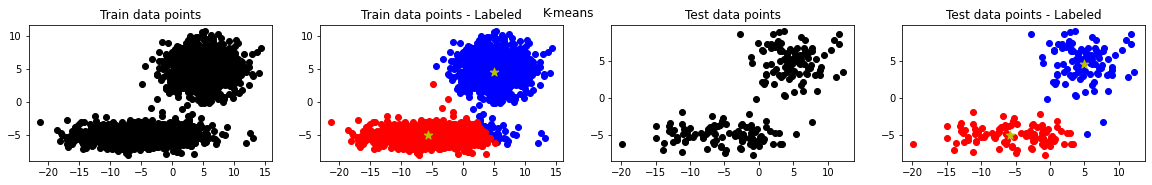

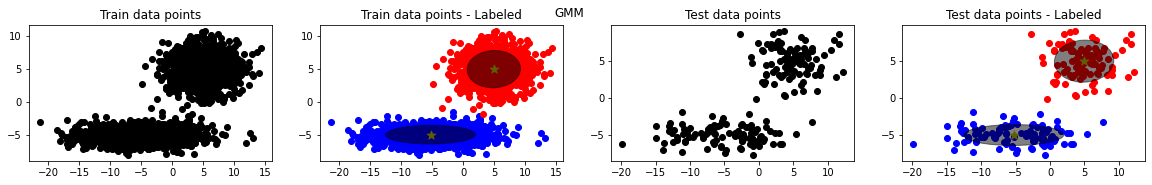

In [ ]:
# generate 2-dimensinonal random datapoints in two different clusters

# Train data
traind = np.float32(
       np.vstack((
       np.random.normal(loc=np.array([5,5]), scale=np.array([3,2]), size=(1000,2)),
       np.random.normal(loc=np.array([-5,-5]), scale=np.array([5,1]), size=(1000,2)))))

# Test data
testd = np.float32(
       np.vstack((
       np.random.normal(loc=np.array([5,5]), scale=np.array([3,2]), size=(100,2)),
       np.random.normal(loc=np.array([-5,-5]), scale=np.array([5,1]), size=(100,2)))))

#---------------------------------- K-means --------------------------------------------


# Training
# Understanding: https://docs.opencv.org/3.4/de/d4d/tutorial_py_kmeans_understanding.html
#
# K-Means Input parameters:
# samples : It should be of np.float32 data type, and each feature should be put in a single column.
# nclusters(K) : Number of clusters required at end
# bestLabels	Input/output integer array that stores the cluster indices for every sample.
# criteria : It is the iteration termination criteria. When this criteria is satisfied, algorithm iteration stops. 
#            Actually, it should be a tuple of 3 parameters. They are ( type, max_iter, epsilon ):
#            3.a - type of termination criteria : It has 3 flags as below:
#                  cv2.TERM_CRITERIA_EPS - stop the algorithm iteration if specified accuracy, epsilon, is reached. 
#                  cv2.TERM_CRITERIA_MAX_ITER - stop the algorithm after the specified number of iterations, max_iter. 
#                  cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER - stop the iteration when any of the above condition is met.
#            3.b - max_iter - An integer specifying maximum number of iterations.
#            3.c - epsilon - Required accuracy
# attempts : Flag to specify the number of times the algorithm is executed using different initial labellings. 
#            The algorithm returns the labels that yield the best compactness. This compactness is returned as output.
# flags : This flag is used to specify how initial centers are taken. Normally two flags are used for this : 
#         cv2.KMEANS_PP_CENTERS (Use kmeans++ center initialization by Arthur and Vassilvitskii [Arthur2007])  and cv2.KMEANS_RANDOM_CENTERS (random centers).
#
# K-Means output parameters:
# compactness : It is the sum of squared distance from each point to their corresponding centers.
# labels : This is the label array where each element marked ‘0’, ‘1’.....
# centers : This is array of centers of clusters.

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1)
compactness, labels, centers = cv2.kmeans(traind, 2, None, criteria, 10, flags=cv2.KMEANS_RANDOM_CENTERS)

print(compactness)

A = traind[labels.ravel()==0]
B = traind[labels.ravel()==1]

plt.figure(figsize=(20,2.5))
plt.subplot(141)
plt.plot(traind[:,0], traind[:,1],"ko")
plt.title("Train data points")
plt.subplot(142)
plt.scatter(A[:,0], A[:,1], color='b')
plt.scatter(B[:,0], B[:,1], color='r')
plt.scatter(centers[:,0], centers[:,1], s=80, color='y', marker='*')
plt.title("Train data points - Labeled")


# Test
# Find the eclidean distance between the test datapoint and the two cluster centers.
# Test datapoint belongs to the cluster whoes mean is closer to the test datapoint.

labels = np.argmin(np.sum((testd[None,:,:] - centers[:,None,:])**2, -1),0)
A = testd[labels==0]
B = testd[labels==1]
# print("testd shape: ",testd.shape)
# print("testd[None,:,:] shape: ",testd[None,:,:].shape)
# print("centers shape: ",centers.shape)
# print("centers[:,None,:] shape: ",centers[:,None,:].shape)
# ssd = (testd[None,:,:] - centers[:,None,:])**2
# print("testd[None,:,:] - centers[:,None,:])**2 shape", ssd.shape)

# plt.figure(figsize=(20,2.5))
plt.subplot(143)
plt.plot(testd[:,0], testd[:,1],"ko")
plt.title("Test data points")
plt.subplot(144)
plt.scatter(A[:,0], A[:,1], color='b')
plt.scatter(B[:,0], B[:,1], color='r')
plt.scatter(centers[:,0], centers[:,1], s=80, color='y', marker='*')
plt.title("Test data points - Labeled")
plt.suptitle("K-means")
plt.show()

#---------------------------------- GMM --------------------------------------------

# A helper function to draw variance
def make_ellipses(gmm, ax):
    K = gmm.means_.shape[0]
    for n in range(K):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color='black')
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

# https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html        
# sklearn.mixture.GaussianMixture(n_components=1,
#                                 covariance_type=’full’,   #{‘full’ (default), ‘tied’, ‘diag’, ‘spherical’}
#                                 tol=0.001,
#                                 reg_covar=1e-06,
#                                 max_iter=100,
#                                 n_init=1,
#                                 init_params=’kmeans’,     #{‘kmeans’, ‘random’}
#                                 weights_init=None,
#                                 means_init=None,
#                                 precisions_init=None,
#                                 random_state=None,
#                                 warm_start=False,
#                                 verbose=0,                
#                                 verbose_interval=10)

# define a GMM class
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')

# fit GMM on train data
clf.fit(traind)

# the centers of the fitted GMM
centers = clf.means_

# predict cluster membership from the fitted GMM 
label = clf.predict(traind)

A = traind[label==0]
B = traind[label==1]

plt.figure(figsize=(20,2.5))
plt.subplot(141)
plt.plot(traind[:,0], traind[:,1],"ko")
plt.title("Train data points")
h = plt.subplot(142)
plt.scatter(A[:,0], A[:,1], color='b')
plt.scatter(B[:,0], B[:,1], color='r')
plt.scatter(centers[:,0], centers[:,1], s=80, color='y', marker='*')
make_ellipses(clf, h)
plt.title("Train data points - Labeled")

# predict cluster membership from the fitted GMM 
label = clf.predict(testd)

A = testd[label==0]
B = testd[label==1]

plt.subplot(143)
plt.plot(testd[:,0], testd[:,1],"ko")
plt.title("Test data points")
h = plt.subplot(144)
plt.scatter(A[:,0], A[:,1], color='b')
plt.scatter(B[:,0], B[:,1], color='r')
plt.scatter(centers[:,0], centers[:,1], s=80, color='y', marker='*')
make_ellipses(clf, h)
plt.title("Test data points - Labeled")

plt.suptitle("GMM")
plt.show()

# print(np.unique(label))

## K-means Segmentation (with OpenCV)

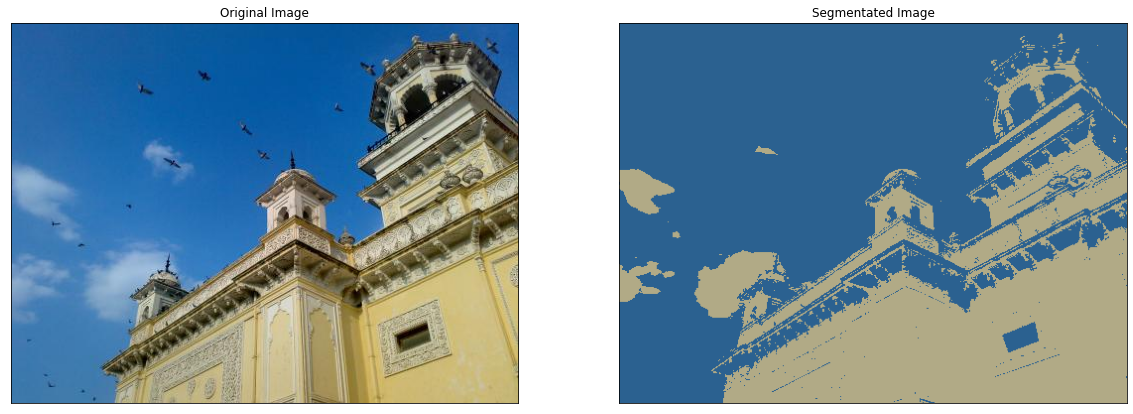

In [ ]:
img = cv2.cvtColor(cv2.imread(path+'home.jpg'), cv2.COLOR_BGR2RGB)
Z = img.reshape((-1,3))

# convert to np.float32
Z = np.float32(Z)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Now convert back into uint8, and make original image
center = np.uint8(center)
out = center[label.flatten()]
out = out.reshape((img.shape))

plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(img)
plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122)
plt.imshow(out)
plt.title("Segmentated Image"), plt.xticks([]), plt.yticks([])
plt.show()

## K-means Segmentation (with skimage)

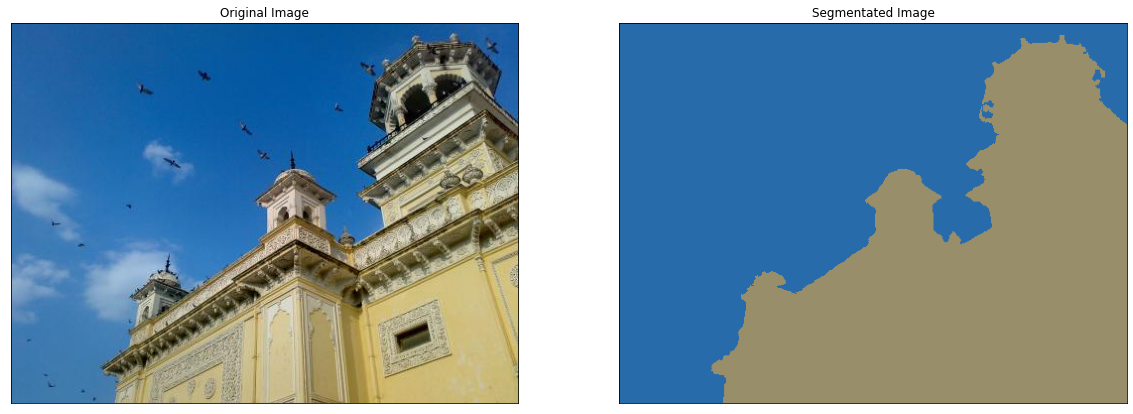

In [ ]:
img = cv2.cvtColor(cv2.imread(path+'home.jpg'), cv2.COLOR_BGR2RGB)

# https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.slic
# slic(image, n_segments=100, compactness=10.0, max_iter=10,
#     sigma=0, spacing=None, multichannel=True, convert2lab=None,
#     enforce_connectivity=True, min_size_factor=0.5, max_size_factor=3, slic_zero=False)

# n_segments : The (approximate) number of labels in the segmented output image.
# compactness: Balances color proximity and space proximity. Higher values give more weight to space proximity.
# spacing: The voxel spacing along each image dimension. By default, slic assumes uniform spacing.
# multichannel: Whether the last axis of the image is to be interpreted as multiple channels or another spatial dimension.
# enforce_connectivity: Whether the generated segments are connected or not
# min_size_factor: Proportion of the minimum segment size to be removed
# max_size_factor: Proportion of the maximum connected segment size.
    
labels = segmentation.slic(img, compactness=0.1, n_segments=2)
out = color.label2rgb(labels, img, kind='avg')

plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(img)
plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122)
plt.imshow(out)
plt.title("Segmentated Image"), plt.xticks([]), plt.yticks([])
plt.show()

## GMM Segmentation

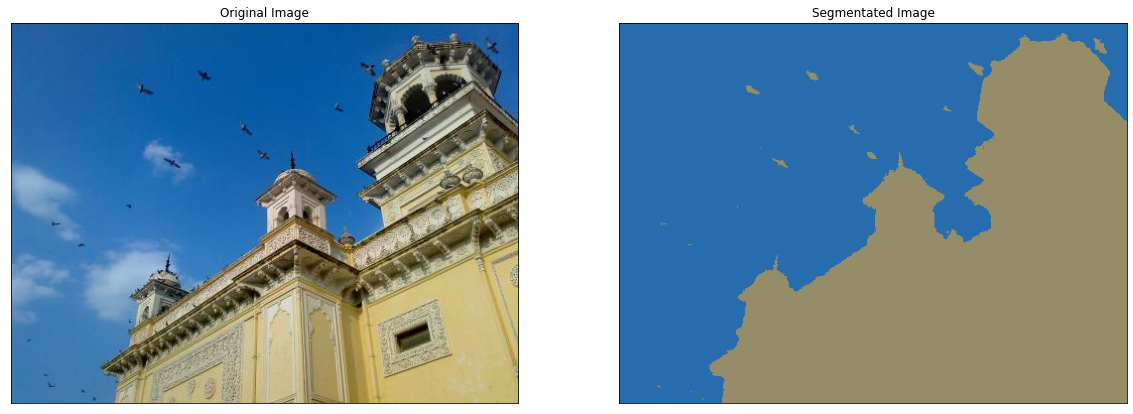

In [ ]:
# Read an image
img = cv2.cvtColor(cv2.imread(path+'home.jpg'), cv2.COLOR_BGR2RGB)

# Arrange img to a feature matrix and convert it to np.float32
Z = img.reshape((-1,3))
Z = np.float32(Z)

# fit GMM on Z
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
clf.fit(Z)

# predict cluster membership from the fitted GMM 
label = clf.predict(Z)

# create a segmentation image
center = np.uint8(clf.means_)
out = center[label.flatten()]
out = out.reshape((img.shape))

# display
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(img)
plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122)
plt.imshow(out)
plt.title("Segmentated Image"), plt.xticks([]), plt.yticks([])
plt.show()

## MeanShift Segmentation

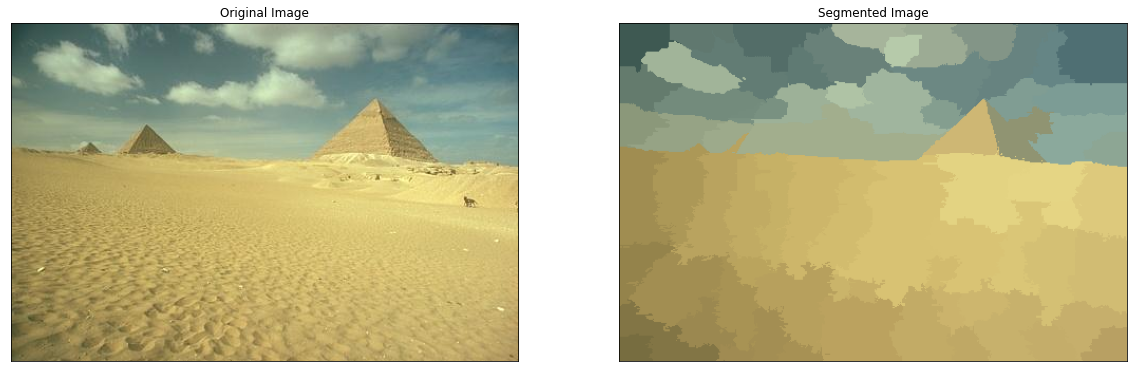

In [ ]:

# Read image
img = cv2.cvtColor(cv2.imread(path+'pyramids.jpg'), cv2.COLOR_BGR2RGB)

#skimage.segmentation.quickshift(image, ratio=1.0, kernel_size=5, max_dist=10,
#                                return_tree=False, sigma=0, convert2lab=True, random_seed=42)
# image(width, height, channels):Input image.
# ratio: ratio of color-space proximity and image-space proximity.
# kernel_size: Variance of Gaussian kernel used in smoothing the sample density.
# max_dist: Cut-off point for data distances.
# return_tree: Whether to return the full segmentation hierarchy tree and distances.
# sigma: Variance of Gaussian smoothing as preprocessing.
# convert2lab: Whether the input should be converted to Lab colorspace prior to segmentation.
# random_seed: Random seed used for breaking ties

# apply meanshift
label = quickshift(img, max_dist=100)
out = color.label2rgb(label, img, kind='avg')

# display
plt.figure(figsize=(20,10))
plt.subplot(121), plt.imshow(img)
plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(out)
plt.title("Segmented Image"), plt.xticks([]), plt.yticks([])
plt.show()

## Graph Cut Segmentation

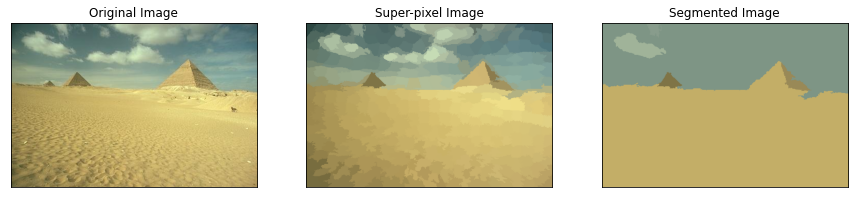

In [ ]:

# Read image
img = cv2.cvtColor(cv2.imread(path+'pyramids.jpg'), cv2.COLOR_BGR2RGB)

# apply k-means. This will generate super pixels
labels1 = segmentation.slic(img, compactness=5, n_segments=400)
out1 = color.label2rgb(labels1, img, kind='avg')


# build region adjacency graph
# rag_mean_color(image, labels, connectivity=2, mode='distance', sigma=255.0)
# connectivity: Pixels with a squared distance less than connectivity from each other are considered adjacent.
# mode: {‘distance’, ‘similarity’}
#         ‘distance’ : The weight between two adjacent regions is the |c1−c2| -> max cut?
#         ‘similarity’ : The weight between two adjacent is e−d2/sigma; where d=|c1−c2| -> min cut?
# sigma: Used for computation when mode is “similarity”.
    
g = graph.rag_mean_color(img, labels1, mode='similarity')

# Apply graph cut
# cut_normalized(labels, rag, thresh=0.001, num_cuts=10, in_place=True, max_edge=1.0)
# labels: The array of labels.
# rag: The region adjacency graph.
# thresh: The threshold. A subgraph won’t be further subdivided if the value of the N-cut exceeds thresh.
# num_cuts: The number or N-cuts to perform before determining the optimal one.
# in_place: If set, modifies rag in place.
# max_edge: The maximum possible value of an edge in the RAG.

labels2 = graph.cut_normalized(labels1, g)
out2 = color.label2rgb(labels2, img, kind='avg')

# display
plt.figure(figsize=(15,5))
plt.subplot(131), plt.imshow(img)
plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(out1)
plt.title("Super-pixel Image"), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(out2)
plt.title("Segmented Image"), plt.xticks([]), plt.yticks([])
plt.show()